<a href="https://colab.research.google.com/github/PineBiotech/omicslogic/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

data = pd.read_table('/content/sample_data/TCGA_Liver_NormFilt_RiskFactor1_train.txt',sep='\t',header=(0))

features = data.iloc[1:, 0].values

data=data.drop(['ID'], axis = 1) 

dataT = np.transpose(data)

X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values

classes = np.unique(y)
n_classes = len(classes)
str(classes)

"['Alcohol' 'HepB' 'HepC' 'NAFLD']"

In [4]:
# initially SVM is a binary (two classes) classifier
# so by default multiclass problems are handled according to a "one-vs-one" scheme.
# if you want to try OneVsRest scheme - you can use OneVsRestClassifier from sklearn as a wrapper around SVC.
# import model class (SVC stands for Support Vector Classification)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale

X = scale(X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# there are several useful parameters such as:
# C - Regularization parameter. The strength of the regularization.
# kernel - Specifies the kernel type to be used in the algorithm
# we will use a linear kernel, it is the only kernel which allows us to use features selection
model = LinearSVC(C=1.0)

In [5]:
# now we can easily train our model on the previously loaded data
model.fit(X_train, y_train)

# after training we can predict labels for the test samples
predictions = model.predict(X_test)
predictions

array(['HepB', 'HepB', 'HepB', 'NAFLD', 'NAFLD', 'HepC', 'HepB', 'NAFLD'],
      dtype=object)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# the weights obtained from svm.coef_ represent the vector coordinates
# which are orthogonal to the hyperplane and their direction indicates the predicted class.
# this is only available in the case of a linear kernel
top_features_count = 50
# we use median of weights from all classes, you can also use np.sum(np.abs(model.coef_, axis=0))
vector_weights = np.median(model.coef_, axis=0)
top_positive_coefficients = np.argsort(vector_weights)[-top_features_count:]
top_negative_coefficients = np.argsort(vector_weights)[:top_features_count]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_features, top_features_weights = features[top_coefficients], vector_weights[top_coefficients]
top_features

array(['ISG159636', 'PGAM25224', 'IFI44L10964', 'RSAD291543',
       'SLC2A56518', 'C19orf21126353', 'INSIGF2723961', 'GSTT12952',
       'OAS24939', 'MX14599', 'PEG35178', 'CHIT11118', 'OAS34940',
       'CMPK2129607', 'IFI62537', 'PGC5225', 'TM4SF2079853',
       'SLC39A455630', 'SQLE6713', 'EPCAM4072', 'IGF23481',
       'SERPINA76906', 'MUC1356667', 'CABYR26256', 'IFI273429',
       'ECEL19427', 'IFI4410561', 'IFIT13434', 'G0S250486', 'PEG1023089',
       'SOCS39021', 'STAT16772', 'DPCR1135656', 'TP53INP194241',
       'COL2A11280', 'FGF2126291', 'IFIT33437', 'CPLX210814',
       'C19orf77284422', 'HLADPA13113', 'HMOX13162', 'LOC9661096610',
       'BST2684', 'OAS14938', 'ACSL42182', 'FLNC2318', 'HLAA3105',
       'HLAB3106', 'CD1639332', 'CD5L922', 'XPNPEP27512', 'CST11469',
       'HHIPL279802', 'FSTL310272', 'KDELR311015', 'LYPD1116372',
       'GLT1D1144423', 'MYOM18736', 'CYP4F28529', 'ETV42118',
       'AGXT2L164850', 'PRSS85652', 'XIST7503', 'S100A1457402',
       'NPC1L1298

In [21]:
#ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
# for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
y_test_bin_labels = label_binarize(y_test, classes=classes)

# for roc curve we are using predicted proba for our test samples
y_score = model.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


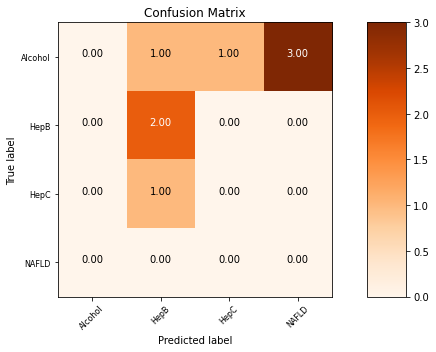

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# plot confusion matrix
plt.figure(figsize=(10, 5))
plt.imshow(c_matrix, cmap=plt.cm.Oranges)
plt.title('Confusion Matrix', size=12)
plt.colorbar(aspect=7)
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, classes, rotation=45, size=8)
plt.yticks(tick_marks, classes, size=8)

fmt = '.2f'
thresh = c_matrix.max() / 2.

for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], fmt), fontsize=10,
                horizontalalignment='center',
                color='white' if c_matrix[i, j] > thresh else 'black')

plt.ylabel('True label', size=10)
plt.xlabel('Predicted label', size=10)
plt.tight_layout()
plt.show()

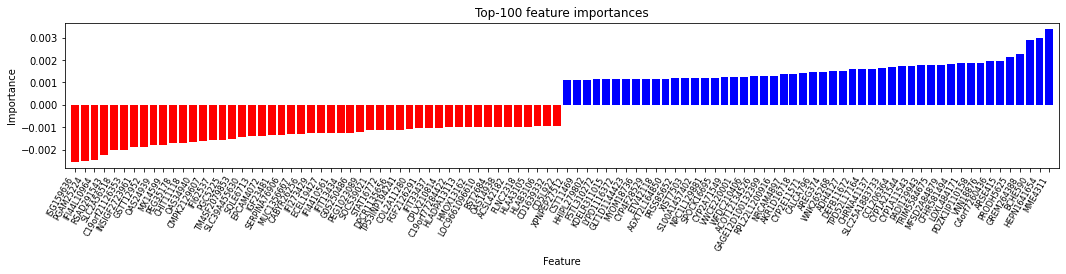

In [26]:
# plot features importances
plt.figure(figsize=(16, 5))
plt.title('Top-{} feature importances'.format(2 * top_features_count), size=12)
colors = ['red' if c < 0 else 'blue' for c in top_features_weights]
plt.bar(np.arange(1, 1 + 2 * top_features_count), top_features_weights, color=colors)
plt.xticks(np.arange(1, 1 + 2 * top_features_count), top_features, rotation=60, ha='right', size=8)
plt.ylabel('Importance', size=10)
plt.xlabel('Feature', size=10)
plt.xlim([0, 2 * top_features_count + 1])
plt.tight_layout(pad=5)
plt.show()

In [24]:
for id in top_features:
    print(id[-4:])

len(top_features)

9636
5224
0964
1543
6518
6353
3961
2952
4939
4599
5178
1118
4940
9607
2537
5225
9853
5630
6713
4072
3481
6906
6667
6256
3429
9427
0561
3434
0486
3089
9021
6772
5656
4241
1280
6291
3437
0814
4422
3113
3162
6610
2684
4938
2182
2318
3105
3106
9332
L922
7512
1469
9802
0272
1015
6372
4423
8736
8529
2118
4850
5652
7503
7402
9881
6695
1549
0001
0406
4526
2399
0916
4897
6718
1571
A796
G374
5268
4127
1672
7164
1137
3733
6364
1544
1543
9943
4675
4879
1494
4171
0158
8876
0436
E415
5625
4388
E590
1654
4311


100